            Time      wfv_1      wfv_2      wfv_3
0  3/23/22 11:15  27.131645  22.632761  23.291329
1  3/23/22 11:30  27.131645  22.446199  23.292771
2  3/23/22 11:45  27.177793  22.634226  23.292771
3  3/23/22 12:00  27.177793  22.446199  23.292771
4  3/23/22 12:15  27.180429  22.446199  23.292771
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14889 entries, 0 to 14888
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    14889 non-null  object 
 1   wfv_1   14887 non-null  float64
 2   wfv_2   14887 non-null  float64
 3   wfv_3   14887 non-null  float64
dtypes: float64(3), object(1)
memory usage: 465.4+ KB
Valori lipsa inainte de interpolare:
 Time     0
wfv_1    2
wfv_2    2
wfv_3    2
dtype: int64
Valori lipsa dupa interpolare:
 Time     0
wfv_1    0
wfv_2    0
wfv_3    0
dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_1100\4007684549.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear')


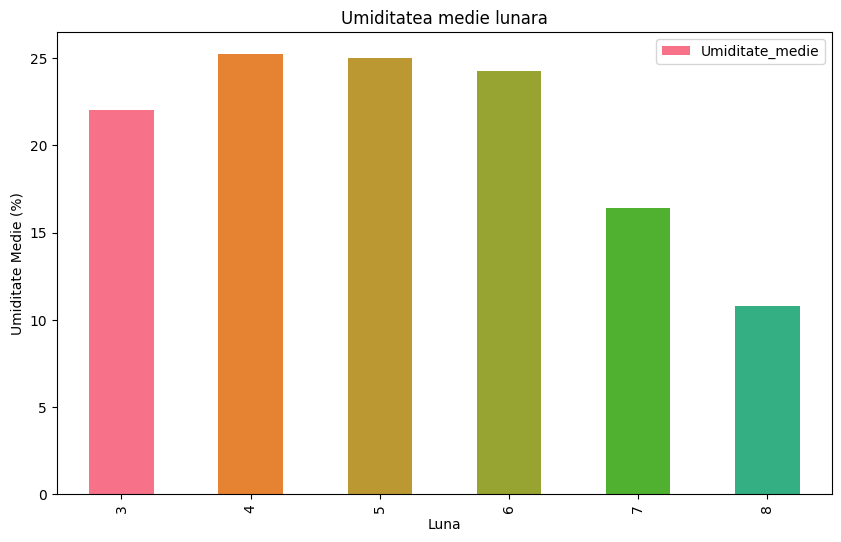

Mean Squared Error: 0.6593
Mean Absolute Error: 0.1909


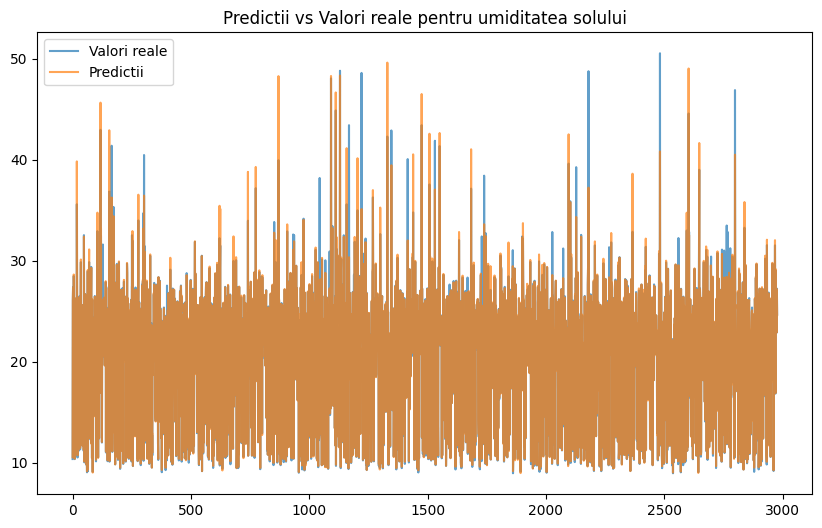

Introduceți data în formatul 'YYYY-MM-DD HH:MM:SS':  2024-12-12 11:11:11
Introduceți umiditatea dorită (%):  30
Introduceți umiditatea curentă (%):  25


Data și ora curentă: 2024-12-12 11:11:11
Decizia sistemului: Udati solul (Umiditate dorita: 30.0%, Umiditate prezisă: 24.6%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime

# Incarcam datasetul
file_path = 'C:\\Users\\Asus\\Desktop\\Facultate\\An 3\\Sem 1\\SBC\\Proiect\\14 - Control of a Smart Irrigation System\\archive 1\\RainGarden.csv'
data = pd.read_csv(file_path)

# Verificam structura datasetului
print(data.head())
data.info()

# Verificam valorile lipsa
print("Valori lipsa inainte de interpolare:\n", data.isnull().sum())

# Interpolare liniara pentru completarea valorilor lipsa
data = data.interpolate(method='linear')
print("Valori lipsa dupa interpolare:\n", data.isnull().sum())

# Convertim coloana `Time` la format datetime
data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%y %H:%M')

# Cream o coloana noua pentru media umiditatii solului
senzori = ['wfv_1', 'wfv_2', 'wfv_3']

data['Umiditate_medie'] = data[senzori].mean(axis=1)

# Extragem trasaturi temporale
data['Hour'] = data['Time'].dt.hour
data['Day'] = data['Time'].dt.day
data['Month'] = data['Time'].dt.month

# Analiza lunara pentru vizualizare

umiditate_pe_luna = data.groupby('Month')['Umiditate_medie'].mean()

# Grafic: Umiditatea medie lunara
plt.figure(figsize=(10, 6))
colors = sns.color_palette('husl', 12)
umiditate_pe_luna.plot(kind='bar', color=colors)
plt.xlabel("Luna")
plt.ylabel("Umiditate Medie (%)")
plt.title("Umiditatea medie lunara")
plt.legend()
plt.show()

# Definim caracteristicile pentru regresie
X_reg = data[['Hour', 'Day', 'Month', 'Umiditate_medie']][:-1]
y_reg = data['Umiditate_medie'].shift(-1)[:-1]

# Impartim datele in seturi de antrenament si test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Antrenam modelul de regresie
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# Facem predictii
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluam modelul de regresie
print(f"Mean Squared Error: {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")

# Grafic: Predictii vs Valori reale pentru umiditatea solului
plt.figure(figsize=(10, 6))
plt.plot(y_test_reg.values, label='Valori reale', alpha=0.7)
plt.plot(y_pred_reg, label='Predictii', alpha=0.7)
plt.legend()
plt.title("Predictii vs Valori reale pentru umiditatea solului")
plt.show()

# Functie pentru decizia de udare folosind predictia modelului

def make_decision(umiditate_dorita, umiditate_curenta, ora, zi, luna, model):
    # Prezicem umiditatea viitoare
    X_new = pd.DataFrame([[ora, zi, luna, umiditate_curenta]], columns=['Hour', 'Day', 'Month', 'Umiditate_medie'])
    umiditate_viitoare = model.predict(X_new)[0]

    # Decizie pe baza umidității viitoare
    if umiditate_dorita > umiditate_viitoare:
        return f"Udati solul (Umiditate dorita: {umiditate_dorita}%, Umiditate prezisă: {umiditate_viitoare:.1f}%)"
    else:
        return f"Nu udati solul (Umiditate dorita: {umiditate_dorita}%, Umiditate prezisă: {umiditate_viitoare:.1f}%)"

# Simulare decizie automatizata
try:
    input_date_str = input("Introduceți data în formatul 'YYYY-MM-DD HH:MM:SS': ")
    input_date = pd.to_datetime(input_date_str, format='%Y-%m-%d %H:%M:%S')
except ValueError:
    print("Formatul datei este invalid. Vă rugăm să încercați din nou.")
    exit()

try:
    umiditate_dorita = float(input("Introduceți umiditatea dorită (%): "))
    umiditate_curenta = float(input("Introduceți umiditatea curentă (%): "))
except ValueError:
    print("Valoarea introdusă nu este validă. Introduceți un număr.")
    exit()

current_hour = input_date.hour
current_day = input_date.day
current_month = input_date.month

# Facem decizia automatizată pe baza datelor introduse
decision = make_decision(umiditate_dorita, umiditate_curenta, current_hour, current_day, current_month, reg_model)

# Afișăm rezultatele
print(f"Data și ora curentă: {input_date.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Decizia sistemului: {decision}")

